In [7]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from layouts import Layout
from layouts.library import surface_code
from layouts.util.transmons import set_freq_groups, set_target_freqs, sample_freqs, get_collisions

# Distance-3 surface code

In [8]:
DISTANCE = 5

GROUP_FREQS = np.array([5.00, 5.07, 5.14, 5.21, 5.28]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.33, len(GROUP_FREQS))

layout = surface_code(DISTANCE, mixed_layout=False)
set_freq_groups(layout)
set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

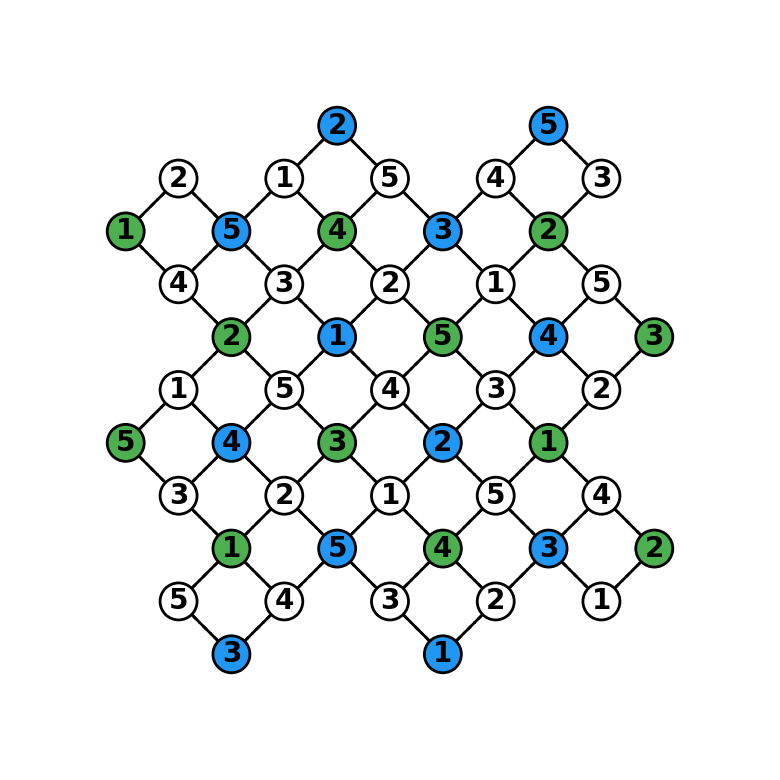

In [9]:
fig, ax = plt.subplots(dpi=200)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

# Scan for distance 3

In [4]:
MAX_FREQ_VAR = 2e-2
NUM_FREQ_VARS = 20
NUM_SEEDS = 50000

FREQ_VARS = np.geomspace(1e-3, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

sampled_collisions = np.zeros((NUM_FREQ_VARS, NUM_SEEDS, 3), dtype=int)

for var_ind, freq_var in enumerate(FREQ_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_freqs(layout, seed, freq_var)
        sampled_collisions[var_ind, seed_ind] = get_collisions(layout)

In [5]:
total_collisions = sampled_collisions.sum(axis = 2)
collision_stats = sampled_collisions.sum(axis = 1)
device_yield = np.mean(total_collisions == 0, axis= 1)

With the spectator collision enabled

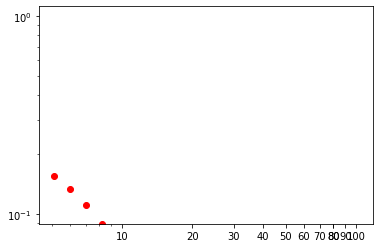

In [10]:
fig, ax = plt.subplots()

qubit_target_freq_vars = [layout.param("target_freq", q) * FREQ_VARS * 1e3 for q in layout.get_qubits()]
mean_freq_vars = np.mean(qubit_target_freq_vars, axis=0)

ax.scatter(mean_freq_vars, device_yield, color="red")
ax.set_xscale("log")

ax.set_yscale("log")
freq_dev_ticks = np.arange(10, 100, )
ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 80, 90, 100])
ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])


plt.show()

With the spectator collision disabled

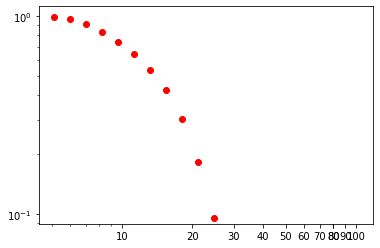

In [138]:
fig, ax = plt.subplots()

qubit_target_freqs = [layout.param("target_freq", q) for q in layout.get_qubits()]
mean_target_freq = np.mean(qubit_target_freqs)

ax.scatter(FREQ_VARS * mean_target_freq * 1e3, device_yield, color="red")
ax.set_xscale("log")

ax.set_yscale("log")
freq_dev_ticks = np.arange(10, 100, )
ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 80, 90, 100])
ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])


plt.show()

# Scan with distance as well

In [139]:
MAX_FREQ_VAR = 1e-2
NUM_FREQ_VARS = 20
NUM_SEEDS = 50000

DISTANCES = [3, 5, 7]
FREQ_VARS = np.geomspace(1e-3, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)


sampled_collisions = np.zeros(
    (len(DISTANCES), NUM_FREQ_VARS, NUM_SEEDS, 3), dtype=int
)

for dist_ind, distance in enumerate(DISTANCES):
    layout = surface_code(distance, mixed_layout=False)
    
    set_freq_groups(layout)
    set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

    for var_ind, freq_var in enumerate(FREQ_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_freqs(layout, seed, freq_var)
            sampled_collisions[dist_ind, var_ind, seed_ind] = get_collisions(layout)

In [143]:
collisions = xr.DataArray(
    sampled_collisions,
    dims = ["distance", "freq_var", "seed", "collision_type"],
    coords = dict(
        distance = DISTANCES,
        freq_var = FREQ_VARS,
        seed = SEEDS,
        collision_type = ["address", "cross_res", "spectator"]
    )
)

In [10]:
LOAD_DATA=True

if LOAD_DATA:
    DISTANCES = [3, 5, 7]
    MAX_FREQ_VAR = 1e-2
    NUM_SEEDS = 50000
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)

    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions = xr.load_dataarray(data_folder/data_arr_name)

In [11]:
total_collisions = collisions.sum(dim="collision_type")
collision_stats = collisions.sum(dim="seed")

zero_collision_runs = xr.where(total_collisions == 0, 1, 0)
device_yield = zero_collision_runs.mean(dim="seed")

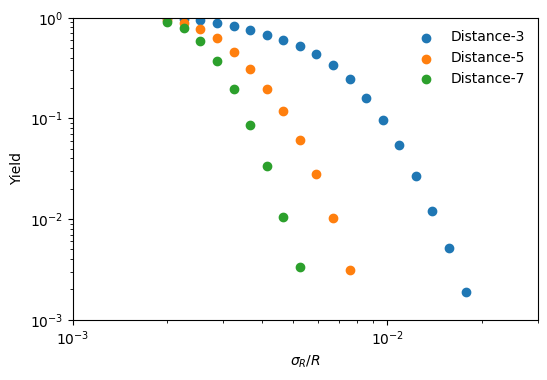

In [12]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.freq_var * 2, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1)
ax.set_xlim(1e-3, 3e-2)
ax.legend(frameon=False)

plt.show()

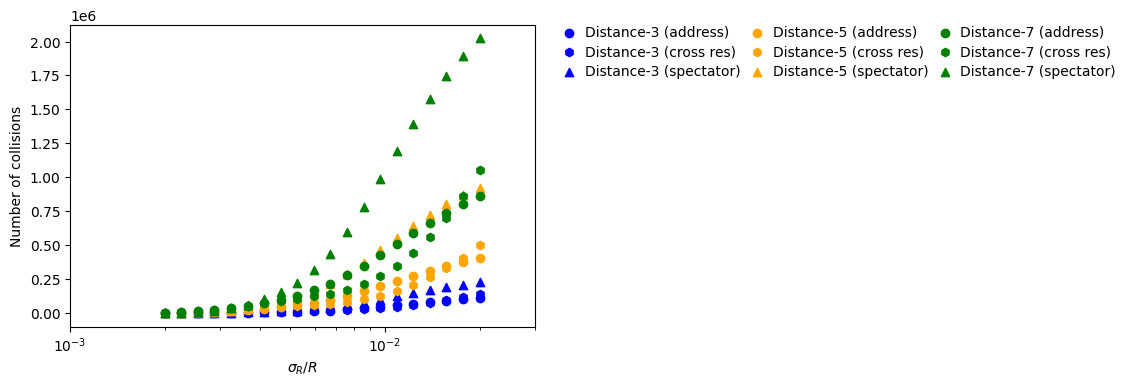

In [17]:
fig, ax = plt.subplots(dpi=100)

markers = dict(
    address = "o",
    cross_res = "h",
    spectator = "^"
)

colors = dict(dist_3 = "blue", dist_5 = "orange", dist_7 = "green")

for dist in collision_stats.distance.values:
    color = colors[f"dist_{dist}"]
    for col_type in collision_stats.collision_type.values:
        
        col_label = "cross res" if col_type == "cross_res" else col_type
        label = f"Distance-{dist} ({col_label})"
        ax.scatter(
            collision_stats.freq_var * 2, 
            collision_stats.sel(distance=dist, collision_type=col_type),
            label=label,
            color=color,
            marker = markers[col_type]
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Number of collisions")
ax.set_xlim(1e-3, 3e-2)
ax.legend(
    frameon=False, 
    ncol=3,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    borderpad=0,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4
)

plt.show()

In [177]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)